In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets
mnist = tensorflow_datasets.load('mnist')

%matplotlib inline

In [ ]:
class RBM(object):
    def __init__(self, visible, hidden):
        """
        visible: Number of neurons in visible layer
        hidden: number of neurons in hidden layer
        """
        self._visible = visible
        self._hidden = hidden



        # Create the Computational graph

        # Weights and biases
        self._W = tf.Variable(tf.random.normal(shape=(self._visible,self._hidden)))
        self._hidden_bias = tf.Variable(np.zeros(self._hidden).astype(np.float32))  #bias for hidden layer
        self._visible_bias = tf.Variable(np.zeros(self._visible).astype(np.float32))  #bias for Visible layer

        # Placeholder for inputs
        self._X = tf.placeholder('float', [None, self._visible])

        # Forwards Pass
        _h = tf.nn.sigmoid(tf.matmul(self._X, self._W) + self._hidden_bias)
        self.h = tf.nn.relu(tf.sign(_h - tf.random_uniform(tf.shape(_h))))


        #Backward pass
        _v = tf.nn.sigmoid(tf.matmul(self.h, tf.transpose(self._W)) + self._visible_bias)
        self.V = tf.nn.relu(tf.sign(_v - tf.random_uniform(tf.shape(_v))))


        # Objective Function
        objective = tf.reduce_mean(self.free_energy(self._X)) - tf.reduce_mean(
                              self.free_energy(self.V))
        self._train_op =  tf.train.GradientDescentOptimizer(1e-3).minimize(objective)

        # Cross entropy cost
        reconstructed_input = self.one_pass(self._X)
        self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self._X, logits=reconstructed_input))



    def set_session(self, session):
        self.session = session



    def free_energy(self, V):
        b = tf.reshape(self._visible_bias, (self._visible, 1))
        term_1 = -tf.matmul(V,b)
        term_1 = tf.reshape(term_1, (-1,))

        term_2 = -tf.reduce_sum(tf.nn.softplus(tf.matmul(V,self._W) + self._hidden_bias))
        return term_1 + term_2

    def one_pass(self, X):
        h = tf.nn.sigmoid(tf.matmul(X, self._W) + self._hidden_bias)
        return tf.matmul(h, tf.transpose(self._W)) + self._visible_bias

    def reconstruct(self,X):
        x = tf.nn.sigmoid(self.one_pass(X))
        return self.session.run(x, feed_dict={self._X: X})

    def rbm_output(self,X):
        x = tf.nn.sigmoid(tf.matmul(X, self._W) + self._hidden_bias)
        return self.session.run(x, feed_dict={self._X: X})


    def fit(self, X, epochs = 1, batch_size = 100):
        N, D = X.shape
        num_batches = N // batch_size

        obj = []
        for i in range(epochs):
            #X = shuffle(X)
            for j in range(num_batches):
                batch = X[j * batch_size: (j * batch_size + batch_size)]
                _, ob = self.session.run([self._train_op,self.cost ], feed_dict={self._X: batch})
                if j % 100 == 0:
                    print('training epoch {0} batch {2} cost {1}'.format((i+1),ob, j))
                obj.append(ob)
        return obj

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/UNI/5th smt/Deep Learning/fer2013/fer2013.csv')
tr_data = data[data.Usage == "Training"]
test_data = data[data.Usage == "PublicTest"]
mask = np.random.rand(len(tr_data)) < 0.8
train_data = tr_data[mask]
val_data = tr_data[~mask]

In [ ]:
def dense_to_one_hot(labels_dense, num_classes):
     num_labels = labels_dense.shape[0]
     index_offset = np.arange(num_labels) * num_classes
     labels_one_hot = np.zeros((num_labels, num_classes))
     labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
     return labels_one_hot

def preprocess_data(dataframe):
     pixels_values = dataframe.pixels.str.split(" ").tolist()
     pixels_values = pd.DataFrame(pixels_values, dtype=int)
     images = pixels_values.values
     images = images.astype(np.float32)
     images = np.multiply(images, 1.0/255.0)
     labels_flat = dataframe["emotion"].values.ravel()
     labels_count = np.unique(labels_flat).shape[0]
     labels = dense_to_one_hot(labels_flat, labels_count)
     labels = labels.astype(np.uint8)
     return images, labels

In [ ]:
X_train, Y_train = preprocess_data(train_data)
X_val, Y_val = preprocess_data(val_data)
X_test, Y_test = preprocess_data(test_data)

<ipython-input-6-26a9ea06e0c9>:10: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  pixels_values = pd.DataFrame(pixels_values, dtype=int)


Training Data set has 22966 images
Validation Data set has 5743 images
Test Data set has 3589 images


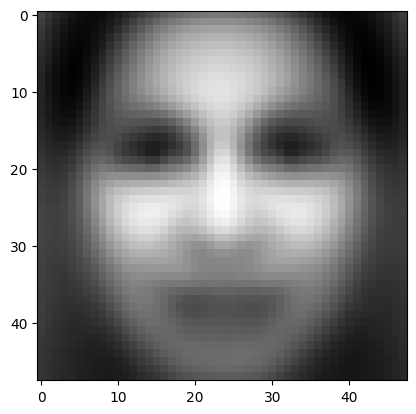

In [ ]:
mean_image = X_train.mean(axis=0)
std_image = np.std(X_train, axis=0)
print("Training Data set has {} images".format(len(X_train)))
print("Validation Data set has {} images".format(len(X_val)))
print("Test Data set has {} images".format(len(X_test)))
plt.imshow(mean_image.reshape(48,48), cmap='gray')

In [ ]:
std_image = np.std(X_train, axis=0)
X_train = np.divide(np.subtract(X_train,mean_image), std_image)
X_val = np.divide(np.subtract(X_val,mean_image), std_image)
X_test = np.divide(np.subtract(X_test,mean_image), std_image)

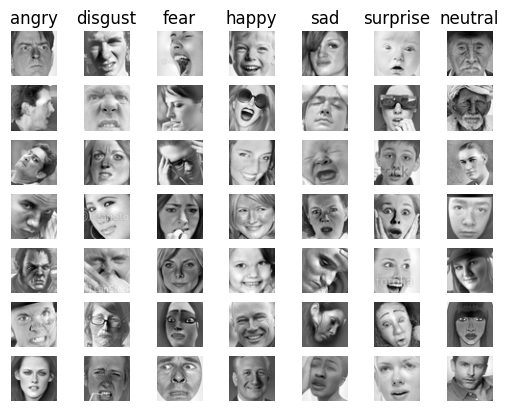

In [ ]:
classes = ['angry','disgust','fear','happy','sad','surprise','neutral']
num_classes = len(classes)
samples_per_class = 7
for y,cls in enumerate(classes):
     idxs = np.flatnonzero(np.argmax(Y_train, axis =1) == y)
     idxs = np.random.choice(idxs, samples_per_class, replace=False)
     for i, idx in enumerate(idxs):
         plt_idx = i * num_classes + y + 1
         plt.subplot(samples_per_class, num_classes, plt_idx)
         plt.imshow(X_train[idx].reshape(48,48), cmap='gray') #pixel height and width
         plt.axis('off')
         if i == 0:
             plt.title(cls)
plt.show()

In [ ]:
RBM_hidden_sizes = [1500, 700, 400, 100] #create 4 layers of RBM with size 1500, 700, 400 and 100
#Set input as training data
inpX = X_train
#Create list to hold our RBMs
rbm_list = []
#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]
#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
     print ('RBM: ',(i+1),' ',input_size,'->', size)
     rbm_list.append(RBM(input_size, size))
     input_size = size

RBM:  1   2304 -> 1500
RBM:  2   1500 -> 700
RBM:  3   700 -> 400
RBM:  4   400 -> 100


In [ ]:
# Greedy wise training of RBMs
init = tf.global_variables_initializer()
for rbm in rbm_list:
     print ('New RBM:')
     #Train a new one
     with tf.Session() as sess:
         sess.run(init)
         rbm.set_session(sess)
         err = rbm.fit(inpX, 30)
         inpX_n = rbm.rbm_output(inpX)
         inpX = inpX_n

New RBM:
training epoch 1 batch 0 cost -0.1432935893535614
training epoch 1 batch 100 cost -840.8818359375
training epoch 1 batch 200 cost -1219.5711669921875
training epoch 2 batch 0 cost -1665.0032958984375
training epoch 2 batch 100 cost -2771.0498046875
training epoch 2 batch 200 cost -2621.1337890625
training epoch 3 batch 0 cost -3338.582275390625
training epoch 3 batch 100 cost -4702.603515625
training epoch 3 batch 200 cost -4022.996826171875
training epoch 4 batch 0 cost -5012.5244140625
training epoch 4 batch 100 cost -6634.49560546875
training epoch 4 batch 200 cost -5424.91455078125
training epoch 5 batch 0 cost -6686.59716796875
training epoch 5 batch 100 cost -8566.5390625
training epoch 5 batch 200 cost -6826.86669921875
training epoch 6 batch 0 cost -8360.732421875
training epoch 6 batch 100 cost -10498.6669921875
training epoch 6 batch 200 cost -8228.82421875
training epoch 7 batch 0 cost -10034.904296875
training epoch 7 batch 100 cost -12430.8515625
training epoch 7 

In [ ]:
import math
class DBN(object):

     def __init__(self, sizes, X, Y, eta = 0.001, momentum = 0.0, epochs = 10, batch_size = 100):
         #Initialize hyperparameters
         self._sizes = sizes
         print(self._sizes)
         self._sizes.append(1000) # size of the first FC layer
         self._X = X
         self._Y = Y
         self.N = len(X)
         self.w_list = []
         self.c_list = []
         self._learning_rate = eta
         self._momentum = momentum
         self._epochs = epochs
         self._batchsize = batch_size
         input_size = X.shape[1]

         #initialization loop
         for size in self._sizes + [Y.shape[1]]:
             #Define upper limit for the uniform distribution range
             max_range = 4 * math.sqrt(6. / (input_size + size))

             #Initialize weights through a random uniform distribution
             self.w_list.append(
             np.random.uniform( -max_range, max_range, [input_size,         size]).astype(np.float32))

             #Initialize bias as zeroes
             self.c_list.append(np.zeros([size], np.float32))
             input_size = size


         # Build DBN
         #Create placeholders for input, weights, biases, output
         self._a = [None] * (len(self._sizes) + 2)
         self._w = [None] * (len(self._sizes) + 1)
         self._c = [None] * (len(self._sizes) + 1)
         self._a[0] = tf.placeholder("float", [None, self._X.shape[1]])
         self.y = tf.placeholder("float", [None, self._Y.shape[1]])

         #Define variables and activation function
         for i in range(len(self._sizes) + 1):
             self._w[i] = tf.Variable(self.w_list[i])
             self._c[i] = tf.Variable(self.c_list[i])
         for i in range(1, len(self._sizes) + 2):
             self._a[i] = tf.nn.sigmoid(tf.matmul(self._a[i - 1], self._w[i - 1]) + self._c[i - 1])

         #Define the cost function
         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits= self._a[-1]))
         #cost = tf.reduce_mean(tf.square(self._a[-1] - self.y))

         #Define the training operation (Momentum Optimizer minimizing the Cost function)
         self.train_op = tf.train.AdamOptimizer(learning_rate=self._learning_rate).minimize(cost)

         #Prediction operation
         self.predict_op = tf.argmax(self._a[-1], 1)

     #load data from rbm
     def load_from_rbms(self, dbn_sizes,rbm_list):
         #Check if expected sizes are correct
         assert len(dbn_sizes) == len(self._sizes)

         for i in range(len(self._sizes)):
             #Check if for each RBN the expected sizes are correct
             assert dbn_sizes[i] == self._sizes[i]

         #If everything is correct, bring over the weights and biases
         for i in range(len(self._sizes)-1):
             self.w_list[i] = rbm_list[i]._W
             self.c_list[i] = rbm_list[i]._hidden_bias


     def set_session(self, session):
         self.session = session

    #Training method
     def train(self, val_x, val_y):
         #For each epoch
         num_batches = self.N // self._batchsize

         batch_size = self._batchsize
         for i in range(self._epochs):
             #For each step
             for j in range(num_batches):
                 batch = self._X[j * batch_size: (j * batch_size + batch_size)]
                 batch_label = self._Y[j * batch_size: (j * batch_size + batch_size)]

                 self.session.run(self.train_op, feed_dict={self._a[0]: batch, self.y: batch_label})

                 for j in range(len(self._sizes) + 1):
                     #Retrieve weights and biases
                     self.w_list[j] = sess.run(self._w[j])
                     self.c_list[j] = sess.run(self._c[j])

             train_acc = np.mean(np.argmax(self._Y, axis=1) == self.session.run(self.predict_op, feed_dict={self._a[0]: self._X, self.y: self._Y}))

             val_acc = np.mean(np.argmax(val_y, axis=1) == self.session.run(self.predict_op, feed_dict={self._a[0]: val_x, self.y: val_y}))
             print (" epoch " + str(i+1) + "/" + str(self._epochs) + " Training Accuracy: " +  str(train_acc) + " Validation Accuracy: " + str(val_acc))

     def predict(self, X):
         return self.session.run(self.predict_op, feed_dict={self._a[0]: X})

In [ ]:
nNet = DBN(RBM_hidden_sizes, X_train, Y_train, epochs = 80)
with tf.Session() as sess:
     #Initialize Variables
     sess.run(tf.global_variables_initializer())
     nNet.set_session(sess)
     nNet.load_from_rbms(RBM_hidden_sizes,rbm_list)
     nNet.train(X_val, Y_val)
     y_pred = nNet.predict(X_test)

[1500, 700, 400, 100]


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



 epoch 1/80 Training Accuracy: 0.1982495863450318 Validation Accuracy: 0.1978060247257531
 epoch 2/80 Training Accuracy: 0.269006357223722 Validation Accuracy: 0.2644959080619885
 epoch 3/80 Training Accuracy: 0.25947052164068624 Validation Accuracy: 0.2568344071043009
 epoch 4/80 Training Accuracy: 0.2823304014630323 Validation Accuracy: 0.27912240989030124
 epoch 5/80 Training Accuracy: 0.27623443351040666 Validation Accuracy: 0.2667595333449417
 epoch 6/80 Training Accuracy: 0.25481146041975095 Validation Accuracy: 0.24638690579836323
 epoch 7/80 Training Accuracy: 0.23160323957154053 Validation Accuracy: 0.2204422775552847
 epoch 8/80 Training Accuracy: 0.2666115126709048 Validation Accuracy: 0.2543966567995821
 epoch 9/80 Training Accuracy: 0.2520247322128364 Validation Accuracy: 0.23611352951419118
 epoch 10/80 Training Accuracy: 0.24005050944875034 Validation Accuracy: 0.22758140344767544
 epoch 11/80 Training Accuracy: 0.24344683445092746 Validation Accuracy: 0.2279296534912067